In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
##### Setup #####
# Read the datasets
path = "data/data_ilr_transformed/"
file_list = [f"{path}d_study{i}_long.csv" for i in range(1, 9)]
df = pd.concat([pd.read_csv(file) for file in file_list], ignore_index=True)
print(f"Combined dataset shape: {df.shape}")

# Define columns
ilr_columns = ['ilr1', 'ilr2', 'ilr3']
control_columns = ['excluded', 'injustice', 'personal', 'violence']
covariate_columns = ['gender', 'age', 'condition']

# Handle NA values and standardize age
for covariate in covariate_columns:
    df = df[df[covariate].notna()]
df[['age']] = StandardScaler().fit_transform(df[['age']])

##### Feature Engineering #####
# Calculate participant-level statistics
for col in ilr_columns:
    df[f'{col}_mean'] = df.groupby('ID')[col].transform('mean')
    df[f'{col}_std'] = df.groupby('ID')[col].transform('std')
    df[f'{col}_min'] = df.groupby('ID')[col].transform('min')
    df[f'{col}_max'] = df.groupby('ID')[col].transform('max')

# Relative time
df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())

# Residualizing ilr variables
from statsmodels.regression.mixed_linear_model import MixedLM

df["Experiment_condition"] = df["Experiment"].astype(str) + "_" + df["condition"].astype(str)
for col in ilr_columns:
    model = MixedLM.from_formula(
        f"{col} ~ excluded*relative_time + injustice*relative_time + personal*relative_time + violence*relative_time + age + gender",
        groups="Experiment",
        data=df
    )
    result = model.fit()
    df[f'{col}_residual'] = df[col] - result.fittedvalues

# Fourier transform (optional)
ilr_resid_columns = ['ilr1_residual', 'ilr2_residual', 'ilr3_residual']
for col in ilr_resid_columns:
    def compute_fourier(x):
        fft_vals = np.fft.fft(x)
        return np.hstack([fft_vals.real[0:1], fft_vals.imag[0:1]])

    fourier_df = (
        df.groupby('ID')[col]
        .apply(lambda x: compute_fourier(x.values))
        .apply(pd.Series)
        .rename(columns=lambda i: f'{col}_fourier_{i}')
    )
    df = df.join(fourier_df, on='ID')

##### Prepare Time Series Data #####
# Define features
feature_columns = [
    'ilr1_mean', 'ilr2_mean', 'ilr3_mean',
    'ilr1_std', 'ilr2_std', 'ilr3_std',
    'ilr1_min', 'ilr2_min', 'ilr3_min',
    'ilr1_max', 'ilr2_max', 'ilr3_max',
    'ilr1_residual_fourier_0', 'ilr2_residual_fourier_0', 'ilr3_residual_fourier_0',
]

# Group data by participant without padding
time_series_data = []
sequence_lengths = []  # Store original lengths for each participant
grouped = df.groupby("ID")

for _, group in grouped:
    time_series = group.sort_values("time")[feature_columns].values
    time_series_data.append(torch.tensor(time_series, dtype=torch.float32))
    sequence_lengths.append(len(time_series))  # Track the length of each sequence

Combined dataset shape: (15424, 18)


In [3]:
##### Deep Learning: Autoencoder #####
# Autoencoder Definition
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(TimeSeriesAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.latent = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, lengths):
        # Pack the padded sequence for variable-length input
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_encoded, (hidden, _) = self.encoder(packed_x)
        encoded, _ = pad_packed_sequence(packed_encoded, batch_first=True)
        z = self.latent(hidden[-1])  # Latent representation
        
        # Decoder input (expand latent representation across time steps)
        z_expanded = z.unsqueeze(1).repeat(1, max(lengths), 1)
        decoded, _ = self.decoder(z_expanded)
        reconstructed = self.output_layer(decoded)
        
        return reconstructed, z

# Hyperparameters
input_dim = len(feature_columns)
latent_dim = 10
hidden_dim = 64
batch_size = 32
num_epochs = 20
learning_rate = 0.01
# Prepare data for PyTorch
# Convert `time_series_data` to a list of PyTorch tensors (no direct tensor conversion yet)
tensor_data = [torch.tensor(ts, dtype=torch.float32) for ts in time_series_data]

# Compute sequence lengths for each time series
sequence_lengths = [len(ts) for ts in tensor_data]

# Pad sequences to create a uniform shape for batching
from torch.nn.utils.rnn import pad_sequence
padded_data = pad_sequence(tensor_data, batch_first=True)  # Pad sequences to match the longest one

# Create a dataset and data loader
dataset = TensorDataset(padded_data, torch.tensor(sequence_lengths))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model = TimeSeriesAutoencoder(input_dim, latent_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    for batch in data_loader:
        optimizer.zero_grad()
        batch_data, batch_lengths = batch
        reconstructed, _ = model(batch_data, batch_lengths)
        
        # Mask to compute loss only for valid timesteps
        mask = torch.arange(batch_data.size(1)).expand(len(batch_lengths), batch_data.size(1)).to(batch_lengths.device) < batch_lengths.unsqueeze(1)
        mask = mask.unsqueeze(2).expand_as(batch_data)  # Expand mask for all features
        
        # Apply mask to compute loss
        loss = criterion(reconstructed[mask], batch_data[mask])
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

# Extract Latent Representations
model.eval()
latent_representations = []
with torch.no_grad():
    for batch in data_loader:
        batch_data, batch_lengths = batch
        _, z = model(batch_data, batch_lengths)
        latent_representations.append(z)

latent_representations = torch.cat(latent_representations, dim=0).numpy()


/var/folders/gj/fcmn9wp14r38t18tn8lsb3qw0000gn/T/ipykernel_20821/3185197703.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_data = [torch.tensor(ts, dtype=torch.float32) for ts in time_series_data]


Epoch 1/20, Loss: 3.2047953605651855
Epoch 2/20, Loss: 7.55536413192749
Epoch 3/20, Loss: 1.728977918624878
Epoch 4/20, Loss: 1.9647897481918335
Epoch 5/20, Loss: 1.6217232942581177
Epoch 6/20, Loss: 1.1427749395370483
Epoch 7/20, Loss: 1.0978772640228271
Epoch 8/20, Loss: 0.9813745021820068
Epoch 9/20, Loss: 1.1425414085388184
Epoch 10/20, Loss: 1.5827823877334595
Epoch 11/20, Loss: 0.9017648100852966
Epoch 12/20, Loss: 1.0997633934020996
Epoch 13/20, Loss: 0.7617567181587219
Epoch 14/20, Loss: 1.340455174446106
Epoch 15/20, Loss: 0.5256123542785645
Epoch 16/20, Loss: 0.626163899898529
Epoch 17/20, Loss: 0.6145333647727966
Epoch 18/20, Loss: 0.48630332946777344
Epoch 19/20, Loss: 0.4950682818889618
Epoch 20/20, Loss: 0.7075795531272888


/Users/arda/GitHub/RadLab/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


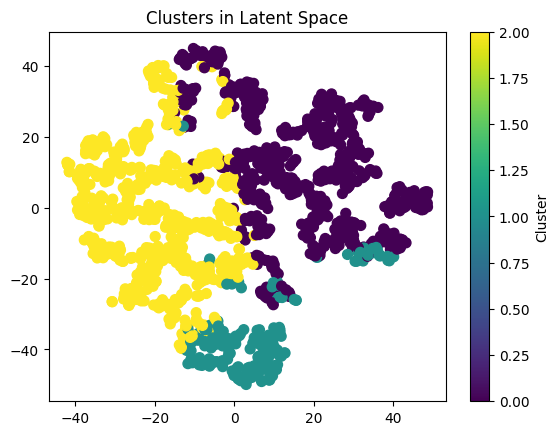

In [4]:
##### Clustering in Latent Space #####
from sklearn.cluster import KMeans
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
latent_labels = kmeans.fit_predict(latent_representations)

# Add latent space clusters to the DataFrame
df["latent_cluster"] = df["ID"].map(dict(zip(grouped.groups.keys(), latent_labels)))

##### Visualization #####
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
reduced_latent = tsne.fit_transform(latent_representations)

plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], c=latent_labels, cmap="viridis", s=50)
plt.colorbar(label="Cluster")
plt.title("Clusters in Latent Space")
plt.show()


In [10]:
# Map latent representations to participant IDs
latent_representations_df = pd.DataFrame(
    latent_representations,
    index=df['ID'].unique(),  # Participant IDs must match the order of latent representations
    columns=[f"latent_dim_{i+1}" for i in range(latent_representations.shape[1])]
)

# Merge latent representations with the original DataFrame
df = df.merge(latent_representations_df, left_on="ID", right_index=True, how="left")

# Import evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Get unique experiments
experiments = df['Experiment'].unique()

# Evaluate clustering per experiment
for exp in experiments:
    # Get participant IDs for this experiment
    exp_ids = df.loc[df['Experiment'] == exp, 'ID'].unique()
    
    # Extract latent representations and cluster labels for this experiment
    exp_latent_representations = latent_representations_df.loc[exp_ids].values
    exp_labels = df.loc[df['ID'].isin(exp_ids), 'latent_cluster'].values
    
    # Ensure there are at least two clusters for valid evaluation
    if len(np.unique(exp_labels)) < 2:
        print(f"Experiment {exp}: Not enough clusters for evaluation.")
        continue

    # Compute Silhouette and Davies-Bouldin Scores
    try:
        sil = silhouette_score(exp_latent_representations, exp_labels)
    except ValueError:
        sil = np.nan
    try:
        db = davies_bouldin_score(exp_latent_representations, exp_labels)
    except ValueError:
        db = np.nan
    
    print(f"Experiment {exp}: Silhouette Score = {sil}, Davies-Bouldin Score = {db}")


Experiment 1: Silhouette Score = nan, Davies-Bouldin Score = nan
Experiment 2: Silhouette Score = nan, Davies-Bouldin Score = nan
Experiment 3: Silhouette Score = nan, Davies-Bouldin Score = nan
Experiment 4: Silhouette Score = nan, Davies-Bouldin Score = nan
Experiment 5: Silhouette Score = nan, Davies-Bouldin Score = nan
Experiment 7: Silhouette Score = nan, Davies-Bouldin Score = nan
Experiment 8: Silhouette Score = nan, Davies-Bouldin Score = nan
